In [35]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [36]:
import torch 
from torch import nn, optim

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Import Data 

In [38]:
df = pd.read_csv("heart_failure_clinical_records.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,748,0,45,0,263358.03,1.3,137,1,1,88,0
1,65.0,0,56,0,25,0,305000.00,5.0,130,1,0,207,0
2,45.0,0,582,1,38,0,319000.00,0.9,140,0,0,244,0
3,60.0,1,754,1,40,1,328000.00,1.2,126,1,0,90,0
4,95.0,1,582,0,30,0,461000.00,2.0,132,1,0,50,1


,missing_value,%
age,0,0.0
anaemia,0,0.0
creatinine_phosphokinase,0,0.0
diabetes,0,0.0
ejection_fraction,0,0.0
high_blood_pressure,0,0.0
platelets,0,0.0
serum_creatinine,0,0.0
serum_sodium,0,0.0
sex,0,0.0


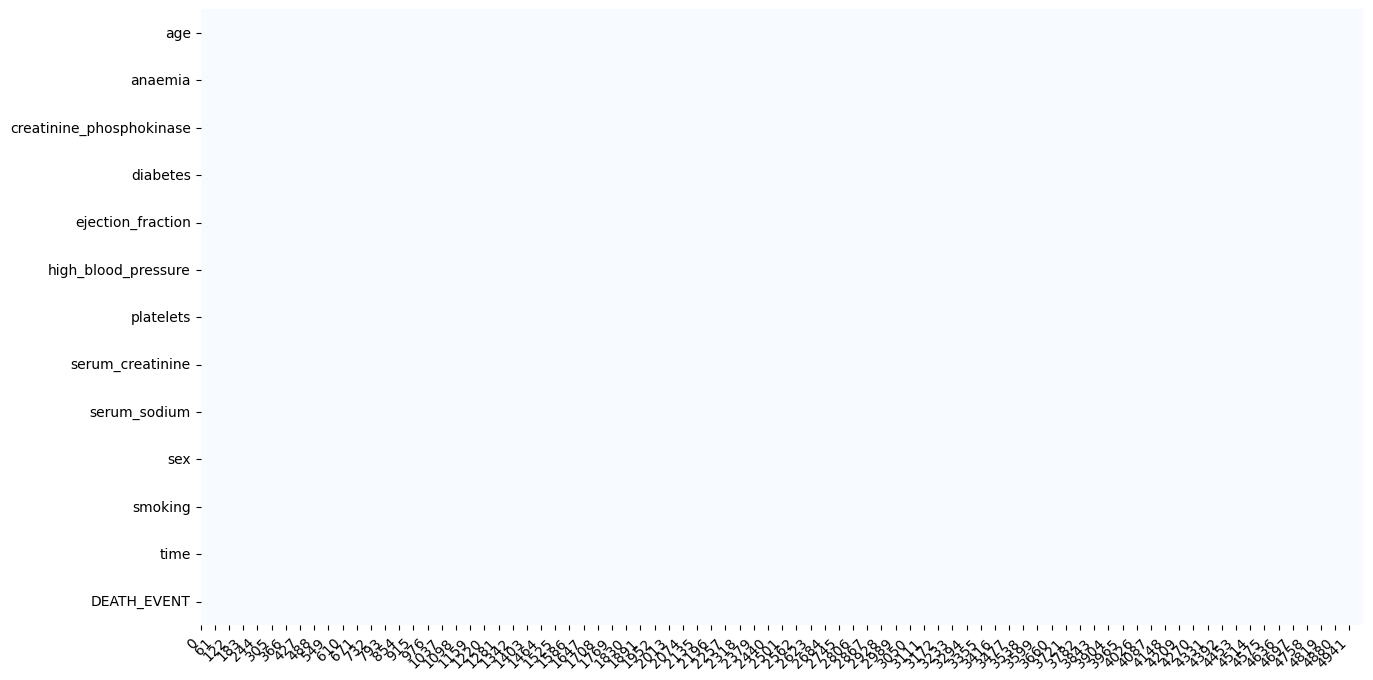

In [39]:
plot_missing_value(df,return_df=True)

In [8]:
df.DEATH_EVENT.value_counts()

0    3432
1    1568
Name: DEATH_EVENT, dtype: int64

# Data Spliting

In [52]:
X = df.drop(columns="DEATH_EVENT")
y = df.DEATH_EVENT.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 12), (1000, 12), (4000,), (1000,))

# Preprocessor Data

In [53]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['age',  'creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine', 'serum_sodium','time']),
    ('categoric', cat_pipe(encoder="onehot"),['anaemia','diabetes','high_blood_pressure','sex','smoking'])
])

In [54]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

C:\Users\ASUS\miniconda3\envs\jcopdl\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


# Dataset dan DataLoader

In [55]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)

# ubah ke longtensor karena label multiclass dan integer 
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [44]:
from torch.utils.data import DataLoader, TensorDataset

In [56]:
train_set = TensorDataset(X_train,y_train)
train_loader = DataLoader(train_set,batch_size=64,shuffle=True)

test_set = TensorDataset(X_test,y_test)
test_loader = DataLoader(test_set,batch_size=64)

In [27]:
len(torch.unique(y_train))

2

# Training Preparation 

In [15]:
X_train.shape[1]

17

# coba improve menggunakan class weigth 

In [36]:
class_counts = [3432, 1568]
total_count = sum(class_counts)
class_weights = [total_count / class_count for class_count in class_counts]
class_weights = torch.tensor(class_weights, device=device)

# MCO

In [37]:
model = nn.Sequential(
    nn.Linear(17, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(0.3),
    
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.3),
    
    nn.Linear(8, 2),
    nn.LogSoftmax(1),
).to(device)
criterion = nn.NLLLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.003)

# Training

In [38]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in dataloader:
        feature, target = feature.to(device), target.to(device)
        output = model(feature) #feed forward
        loss = criterion(output, target) #hitung loss
        
        if mode == "train":
            loss.backward() #backpropagation
            optimizer.step() #updateweight
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [39]:
epoch = 1000
train_cost, test_cost = [],[]
train_acc, test_acc = [],[]
for i in range(epoch):
    cost,acc = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    train_cost.append(cost)
    train_acc.append(acc)
    with torch.no_grad():
        cost,acc = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
        test_cost.append(cost)
        test_acc.append(acc)
        
    print(f"\rEpoch {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f} | "
          f"train_acc: {train_acc[-1]:.4f} test_acc: | {test_acc[-1]:.4f}", end=" ")

Epoch 1000/1000 | train_cost: 0.6933 | test_cost: 0.6931 | train_acc: 0.6865 test_acc: | 0.6860 

In [30]:
import matplotlib.pyplot as plt

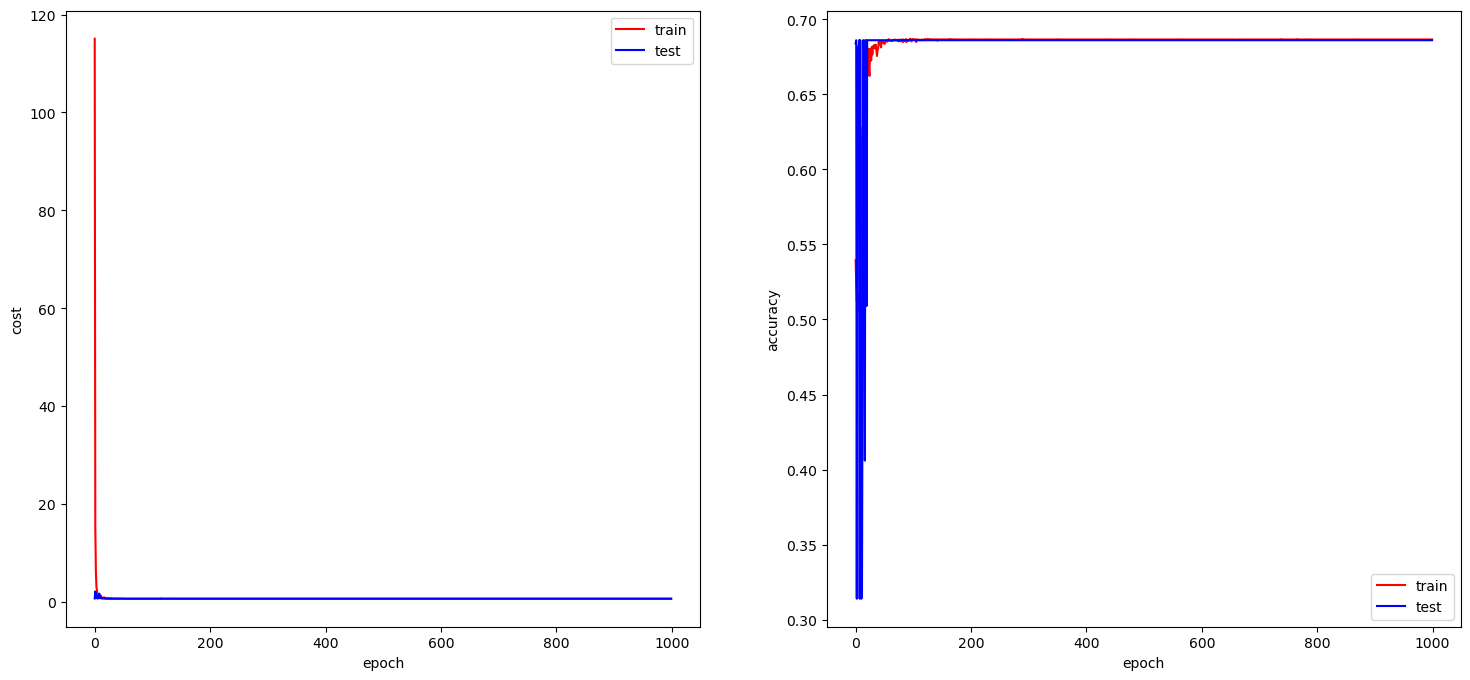

In [31]:
plt.figure(figsize=(18,8))

plt.subplot(121)
plt.plot(train_cost, 'r-', label='train')
plt.plot(test_cost, 'b-', label='test')
plt.xlabel("epoch")
plt.ylabel('cost')
plt.legend();

plt.subplot(122)
plt.plot(train_acc, 'r-', label='train')
plt.plot(test_acc, 'b-', label='test')
plt.xlabel("epoch")
plt.ylabel('accuracy')
plt.legend();

# Try with callback

# Arsitektur dan config

In [57]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config


from jcopdl.layers import linear_block


In [58]:
class HeartFailureClassifier (nn.Module):
    def __init__(self, input_size, n1, n2,n3, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout),
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, n3, dropout=dropout),
            linear_block(n3, output_size, activation="lsoftmax")
        )
        
    
    def forward(self,x):
        return self.fc(x)

In [59]:
config = set_config({
    "input_size" : 17,
    "n1": 32,
    "n2": 16,
    "n3": 8,
    "output_size": len(torch.unique(y_train)),
    "dropout":0.2
})

# Training Preparation MCOC

In [60]:
model = HeartFailureClassifier(config.input_size, config.n1, config.n2, config.n3, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)
callback = Callback(model, config, outdir='model')

# Training 

In [61]:
from tqdm.auto import tqdm


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader,desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/63 [00:00<?, ?it/s]

Test:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1302.9592 | Test_cost  = 124.7784 | Train_score = 0.5577 | Test_score = 0.6860 |


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Test:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 225.1200 | Test_cost  = 14.4072 | Train_score = 0.5543 | Test_score = 0.6870 |


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Test:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 68.4795 | Test_cost  = 1.4920 | Train_score = 0.5573 | Test_score = 0.6870 |
==> EarlyStop patience =  1 | Best test_score: 0.6870


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Test:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 32.6359 | Test_cost  = 0.6386 | Train_score = 0.5373 | Test_score = 0.6820 |
==> EarlyStop patience =  2 | Best test_score: 0.6870


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Test:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 21.3295 | Test_cost  = 0.7848 | Train_score = 0.5185 | Test_score = 0.3140 |
==> EarlyStop patience =  3 | Best test_score: 0.6870


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Test:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 9.1097 | Test_cost  = 0.6347 | Train_score = 0.5275 | Test_score = 0.6810 |
==> EarlyStop patience =  4 | Best test_score: 0.6870


Train:   0%|          | 0/63 [00:00<?, ?it/s]

Test:   0%|          | 0/16 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 7.7544 | Test_cost  = 0.6989 | Train_score = 0.5200 | Test_score = 0.3480 |
==> EarlyStop patience =  5 | Best test_score: 0.6870
==> Execute Early Stopping at epoch: 7 | Best test_score: 0.6870
==> Best model is saved at model


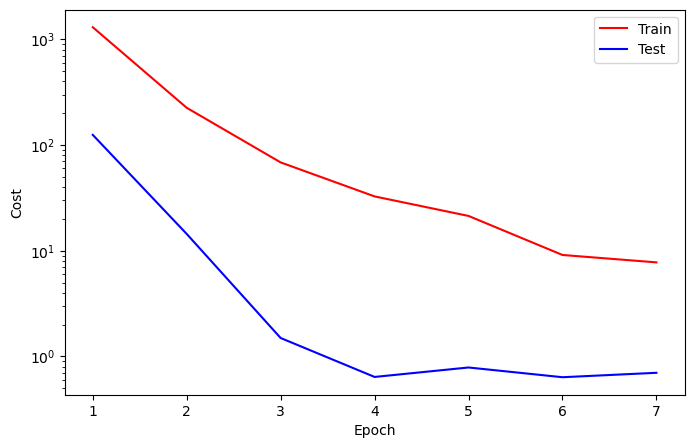

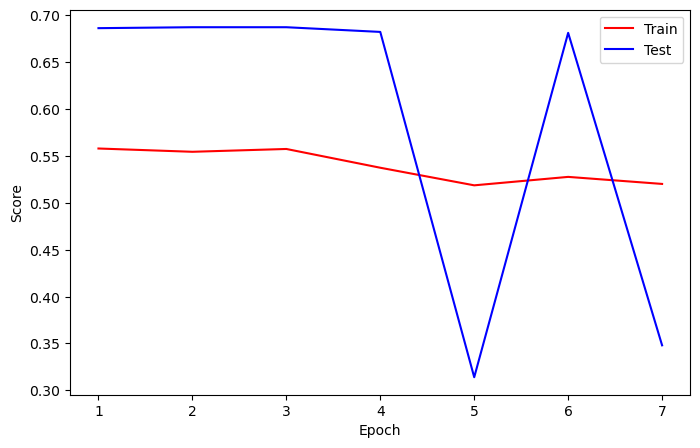

In [62]:
while True:
    train_cost ,train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, test_loader, model, criterion, optimizer, device)
    
    # logging
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break
    